Pretraining Autoencoder for Downstream Tasks
===

## Overview

In this notebook, we train a mini VGG-based autoencoder on the MNIST dataset.

## Setup

We setup our libraries.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__author__ = 'Abien Fred Agarap'
__version__ = '1.0.0'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tf.vgg_ae import CAE

Set eager mode for `tfds`.

In [2]:
tf.compat.v1.enable_eager_execution()

Set the memory growth of GPU.

In [3]:
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0], True
)

Set the random number generator seed value.

In [4]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

We set the batch size and epochs.

In [5]:
batch_size = 64
epochs = 100

## Dataset

We load our dataset.

In [6]:
train_dataset = tfds.load('emnist/letters', split=tfds.Split.TRAIN)

We define a normalization function.

In [7]:
def normalize(example):
    features = example['image']
    return tf.cast(features, tf.float32) / 255., tf.cast(features, tf.float32) / 255.

We customize our `tf.data.Data` object.

In [8]:
train_dataset = train_dataset.map(normalize)
train_dataset = train_dataset.shuffle(1024)
train_dataset = train_dataset.batch(batch_size, True)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
model = CAE(input_shape=(28, 28, 1))

In [10]:
for batch_features, _ in train_dataset:
    model(batch_features)
    break

In [11]:
model.summary()

Model: "cvae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  64992     
_________________________________________________________________
decoder (Decoder)            multiple                  92609     
Total params: 157,601
Trainable params: 157,601
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss=tf.losses.mean_squared_error, optimizer=tf.optimizers.Adam(learning_rate=1e-3))

In [13]:
model.fit(train_dataset, epochs=10, verbose=2)

Epoch 1/10
1387/1387 - 55s - loss: 0.0037
Epoch 2/10
1387/1387 - 54s - loss: 2.0157e-04
Epoch 3/10
1387/1387 - 54s - loss: 1.3871e-04
Epoch 4/10
1387/1387 - 54s - loss: 1.0416e-04
Epoch 5/10
1387/1387 - 54s - loss: 6.8778e-05
Epoch 6/10
1387/1387 - 54s - loss: 7.6458e-05
Epoch 7/10
1387/1387 - 54s - loss: 5.2517e-05
Epoch 8/10
1387/1387 - 54s - loss: 4.4545e-05
Epoch 9/10
1387/1387 - 54s - loss: 3.8837e-05
Epoch 10/10
1387/1387 - 54s - loss: 7.2882e-05


In [14]:
test_dataset = tfds.load('emnist/letters', split=tfds.Split.TEST, batch_size=-1)
test_dataset = tfds.as_numpy(test_dataset)
test_features = test_dataset['image']
test_features = test_features.astype('float32') / 255.

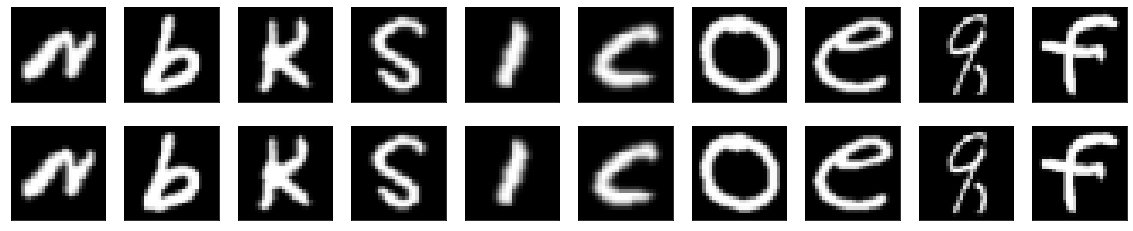

In [15]:
number = 10
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    test_image = test_features[index]
    test_image = tf.transpose(test_image)
    test_image = test_image.numpy().reshape(28, 28)
    plt.imshow(test_image)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    reconstructed = model(test_image.reshape(-1, 28, 28, 1))
    reconstructed = reconstructed.numpy().reshape(28, 28)
    plt.imshow(reconstructed)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
model.save_weights('../assets/export/emnist/mini_vgg_ae_emnist', save_format='tf')